### Model Selection and Comparison

In [1]:
import numpy as np 
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, \
GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading in cleaned data
data = pd.read_csv('reddit_model.csv')

In [3]:
data.head()

,subreddit,title,selftext,created_utc,pro_title,pro_selftext,lem_title,lem_selftext
0,1,$TK &amp; $TNK,Thoughts on Teekay (TK) &amp; Teekay Tankers (...,1587476965,TK amp TNK,Thoughts on Teekay TK amp Teekay Tankers TNK T...,TK amp TNK,Thoughts on Teekay TK amp Teekay Tankers TNK T...
1,1,Investing Frameworks,Are there any frameworks/ concepts that you ha...,1587474494,Investing Frameworks,Are there any frameworks concepts that you hav...,Investing Frameworks,Are there any framework concept that you have ...
2,1,Long term growth calculation,"Hi there, \n\n&amp;#x200B;\n\nI want to valuat...",1587474287,Long term growth calculation,Hi there \n\nampx200B\n\nI want to valuate a c...,Long term growth calculation,Hi there ampx200B I want to valuate a company ...
3,1,Is this the perfect time for NEW companies to ...,This pandemic has demonstrated how badly thing...,1587473864,Is this the perfect time for NEW companies to ...,This pandemic has demonstrated how badly thing...,Is this the perfect time for NEW company to ta...,This pandemic ha demonstrated how badly thing ...
4,1,Is anyone else losing faith in the stock market?,"Maybe stocks will crash again, maybe stocks wi...",1587473142,Is anyone else losing faith in the stock market,Maybe stocks will crash again maybe stocks wil...,Is anyone else losing faith in the stock market,Maybe stock will crash again maybe stock will ...


In [4]:
data.subreddit.value_counts(normalize=True)

1    0.515065
0    0.484935
Name: subreddit, dtype: float64

In [5]:
# Checking for nulls
data.isnull().sum()

# dropping nulls
data.dropna(inplace=True)

In [6]:
data.shape

(24400, 8)

In [7]:
# Creating X, y
X = data['lem_selftext']
y = data['subreddit']

In [8]:
# Creating train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size = 0.3)

### Multinomial Naive Bayes w/ CountVectorizer

In [9]:
# Instantiating Countvectorizer and MultinomialNB
cvec_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])


In [10]:
# Creating Parameters for transformer and estimator
cvec_params = {
    'cvec__max_features': np.arange(1_000, 3_000, 500),
      'cvec__stop_words': ['english'],
     'cvec__ngram_range': [(1,1), (1,2), (1,3)],
            'mnb__alpha': [1.5, 2.0, 2.5, 3.0, 5.0]
}


In [11]:
# Gridsearching parameters
gs_cvec_mnb = GridSearchCV(cvec_mnb, cvec_params, cv=5, n_jobs=-1)

gs_cvec_mnb.fit(X_train,
                y_train)
print(f"Train Score: {gs_cvec_mnb.score(X_train, y_train)}")
print(f"Test Score: {gs_cvec_mnb.score(X_test, y_test)}")
print(f"Best Parameters CVEC-MNB: {gs_cvec_mnb.best_params_}")
# Generating Predictions and ROC-AUC Score
preds = gs_cvec_mnb.predict(X_test)
roc_cvec_mnb = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_cvec_mnb}")

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Train Score: 0.860480093676815
Test Score: 0.8540983606557377
Best Parameters CVEC-MNB: {'cvec__max_features': 2500, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'mnb__alpha': 2.5}


### Logistic Regression w/ CountVectorizer

In [21]:
cvec_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words=True)),
    ('lr', LogisticRegression())
])

cvec_params = {
    'cvec__max_features': [2_000],
      'cvec__stop_words': ['english'],
     'cvec__ngram_range': [(1,1), (1,2), (1, 3)],
           'lr__penalty': ['l1', 'l2'],
                 'lr__C': np.linspace(.001, 5, 15),
            'lr__solver': ['liblinear']
}


In [22]:
%%time

gs_cvec_lr = GridSearchCV(cvec_lr, cvec_params, cv=5, n_jobs=-1)
gs_cvec_lr.fit(X_train, y_train)


print(f"Train Score: {gs_cvec_lr.score(X_train, y_train)}")
print(f"Test Score: {gs_cvec_lr.score(X_test, y_test)}")
print(f"Best Parameters CVEC-LR: {gs_cvec_lr.best_params_}")
preds = gs_cvec_lr.predict(X_test)
roc_cvec_lr = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_cvec_lr}")

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Train Score: 0.9042154566744731
Test Score: 0.8733606557377049
Best Parameters CVEC-LR: {'cvec__max_features': 2000, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english', 'lr__C': 0.35807142857142854, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
CPU times: user 21.4 s, sys: 10 s, total: 31.5 s
Wall time: 8min 14s


### Logistic Regression w/ TfidfVectorizer

In [24]:

tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

tvec_params = {
    'tvec__max_features': [2_000],
      'tvec__stop_words': ['english'],
     'tvec__ngram_range': [(1,1), (1,2), (1, 3)],
           'lr__penalty': ['l1', 'l2'],
                 'lr__C': np.linspace(.001, 5, 15),
            'lr__solver': ['liblinear']
}

In [25]:
%%time

gs_tvec_lr = GridSearchCV(tvec_lr, tvec_params, cv=5, n_jobs=-1)
gs_tvec_lr.fit(X_train, y_train)

In [116]:
print(f"Train Score: {gs_tvec_lr.score(X_train, y_train)}")
print(f"Test Score: {gs_tvec_lr.score(X_test, y_test)}")
print(f"Best Parameters TVEC-LR: {gs_tvec_lr.best_params_}")
# gs_tvec_lr.best_estimator_.named_steps.tvec.get_feature_names()
preds = gs_tvec_lr.predict(X_test)
roc_tvec_lr = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_tvec_lr}")

Train Score: 0.9087236533957845
Test Score: 0.8831967213114754
Best Parameters TVEC-LR: {'lr__C': 1.429285714285714, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [115]:
# Saving coefs in a variable
coefs = gs_tvec_lr.estimator.named_steps.lr.coef_

AttributeError: 'list' object has no attribute 'lr'

### BaggingClassifier w/ CountVectorizer

In [27]:
cvec_bagcl = Pipeline([
    ('cvec', CountVectorizer()),
    ('bagcl', BaggingClassifier())
])

cvec_params = {
    'cvec__max_features': [2_000],
      'cvec__stop_words': ['english'],
     'cvec__ngram_range': [(1,1), (1,2), (1, 3)],
    'bagcl__max_samples': [1_000, 2_000]
}

In [28]:
%%time

gs_bagcl_cvec = GridSearchCV(cvec_bagcl, cvec_params, cv=5, n_jobs=-1)
gs_bagcl_cvec.fit(X_train, y_train)
print(f"Train Score: {gs_bagcl_cvec.score(X_train, y_train)}")
print(f"Test Score: {gs_bagcl_cvec.score(X_test, y_test)}")
print(f"Best Parameters LR-CVEC: {gs_bagcl_cvec.best_params_ }")
preds = gs_bagcl_cvec.predict(X_test)
roc_bagcl_cvec = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_bagcl_cvec}")

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Train Score: 0.8597189695550351
Test Score: 0.8378415300546448
Best Parameters LR-CVEC: {'bagcl__max_samples': 2000, 'cvec__max_features': 2000, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': 'english'}
CPU times: user 12.5 s, sys: 673 ms, total: 13.1 s
Wall time: 38.1 s


### BaggingClassifier w/ TfidfVectorizer

In [30]:
tvec_bagcl = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bagcl', BaggingClassifier())
])

tvec_params = {
    'tvec__max_features': [2_000],
      'tvec__stop_words': ['english'],
     'tvec__ngram_range': [(1,1), (1,2), (1, 3)],
    'bagcl__max_samples': [1_000, 2_000]
}

In [31]:
%%time

gs_bagcl_tvec = GridSearchCV(tvec_bagcl, tvec_params, cv=5, n_jobs=-1)
gs_bagcl_tvec.fit(X_train, y_train)
print(f"Train Score: {gs_bagcl_tvec.score(X_train, y_train)}")
print(f"Test Score: {gs_bagcl_tvec.score(X_test, y_test)}")
print(f"Best Parameters LR-TVEC: {gs_bagcl_tvec.best_params_ }")
preds = gs_bagcl_tvec.predict(X_test)
roc_bagcl_tvec = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_bagcl_tvec}")

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Train Score: 0.8668618266978922
Test Score: 0.8392076502732241
Best Parameters LR-TVEC: {'bagcl__max_samples': 2000, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
CPU times: user 9.4 s, sys: 486 ms, total: 9.89 s
Wall time: 33.8 s


### Support Vector Classifier w/ CountVectorizer

In [33]:
svc_cvec_params = {
    'cvec__max_features': np.arange(1_500, 3_500, 500),
      'cvec__stop_words': ['english'],
     'cvec__ngram_range': [(1,1), (1,2), (1, 3)],
           'svc__degree': [2],
                'svc__C': [2.0, 3.0, 5.0]
}
svc_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())
])

In [34]:
%%time

gs_svc_cvec = GridSearchCV(svc_cvec, svc_cvec_params, cv=5, n_jobs=-1)

gs_svc_cvec.fit(X_train, y_train)
print(f"Train Score: {gs_svc_cvec.score(X_train, y_train)}")
print(f"Test Score: {gs_svc_cvec.score(X_test, y_test)}")
print(f"Best Parameters SVC-CVEC: {gs_svc_cvec.best_params_ }")
preds = gs_svc_cvec.predict(X_test)
roc_svc_cvec = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_svc_cvec}")

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Train Score: 0.9255269320843091
Test Score: 0.8734972677595628
Best Parameters SVC-CVEC: {'cvec__max_features': 2000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'svc__C': 5.0, 'svc__degree': 2}
CPU times: user 54.3 s, sys: 4.53 s, total: 58.8 s
Wall time: 11min 14s


### Support Vector Classifier w/ TfidfVectorizer

In [36]:
svc_tvec_params = {
    'tvec__max_features': [750],
      'tvec__stop_words': ['english'],
     'tvec__ngram_range': [(1,1)],
           'svc__degree': [2],
                'svc__C': [5.0]
}
svc_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

In [37]:
%%time

gs_svc_tvec = GridSearchCV(svc_tvec, svc_tvec_params, cv=5, n_jobs=-1)

gs_svc_tvec.fit(X_train, y_train)
print(f"Train Score: {gs_svc_tvec.score(X_train, y_train)}")
print(f"Test Score: {gs_svc_tvec.score(X_test, y_test)}")
print(f"Best Parameters SVC-TVEC: {gs_svc_tvec.best_params_ }")
preds = gs_svc_tvec.predict(X_test)
roc_svc_tvec = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_svc_tvec}")

Train Score: 0.9908079625292741
Test Score: 0.8786885245901639
Best Parameters SVC-TVEC: {'svc__C': 5.0, 'svc__degree': 2, 'tvec__max_features': 750, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}
CPU times: user 1min 41s, sys: 529 ms, total: 1min 42s
Wall time: 2min 38s


### Random Forrest Classifier w/ CountVectorizer

In [39]:
cvec_params = {
    'cvec__max_features': [500, 1_000, 1_500],
      'cvec__stop_words': ['english'],
     'cvec__ngram_range': [(1,1), (1,2), (1,3)],
     'rfc__n_estimators': [50, 100],
'rfc__min_samples_split': [5, 8, 10],
 'rfc__min_samples_leaf': [3, 5, 8]
}

cvec_rfc = Pipeline([
    ('cvec', CountVectorizer()),
    ('rfc', RandomForestClassifier())
])

In [40]:
%%time

gs_rfc_cvec = GridSearchCV(cvec_rfc, param_grid=cvec_params, cv=5, n_jobs=-1)

gs_rfc_cvec.fit(X_train, y_train)
print(f"Train Score: {gs_rfc_cvec.score(X_train, y_train)}")
print(f"Test Score: {gs_rfc_cvec.score(X_test, y_test)}")
print(f"Best Parameters RFC-CVEC: {gs_rfc_cvec.best_params_ }")
preds = gs_rfc_cvec.predict(X_test)
roc_rfc_cvec = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_rfc_cvec}")

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Train Score: 0.9218384074941453
Test Score: 0.8793715846994535
Best Parameters RFC-CVEC: {'cvec__max_features': 1500, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'rfc__min_samples_leaf': 3, 'rfc__min_samples_split': 8, 'rfc__n_estimators': 100}
CPU times: user 31.9 s, sys: 25.8 s, total: 57.6 s
Wall time: 12min 29s


### Random Forrest Classifier w/ TfidfVectorizer

In [42]:
tvec_params = {
    'tvec__max_features': [1_000],
      'tvec__stop_words': ['english'],
     'tvec__ngram_range': [(1,1), (1,2), (1,3)],
     'rfc__n_estimators': [50, 100],
'rfc__min_samples_split': [5, 8, 10],
 'rfc__min_samples_leaf': [3, 5, 8]
}

tvec_rfc = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfc', RandomForestClassifier())
])

In [43]:
%%time

gs_rfc_tvec = GridSearchCV(tvec_rfc, param_grid=tvec_params, cv=5, n_jobs=-1)

gs_rfc_tvec.fit(X_train, y_train)
print(f"Train Score: {gs_rfc_tvec.score(X_train, y_train)}")
print(f"Test Score: {gs_rfc_tvec.score(X_test, y_test)}")
print(f"Best Parameters RFC-TVEC: {gs_rfc_tvec.best_params_ }")
preds = gs_rfc_tvec.predict(X_test)
roc_rfc_tvec = roc_auc_score(y_test, 
                             preds)
print(f"ROC-AUC Score {roc_rfc_tvec}")

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Train Score: 0.9363583138173303
Test Score: 0.8754098360655738
Best Parameters RFC-TVEC: {'rfc__min_samples_leaf': 3, 'rfc__min_samples_split': 10, 'rfc__n_estimators': 100, 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': 'english'}
CPU times: user 25.3 s, sys: 9.11 s, total: 34.4 s
Wall time: 5min


### Voting Classifier w/ CountVectorizer

In [45]:
('clf', VotingClassifier(n_jobs=-1, estimators=[('clf1', DecisionTreeClassifier(max_depth= [2, 5])), 
                                                ('clf2', SVC(degree = 2)), 
                                                ('clf3', GradientBoostingClassifier(n_estimators= [50, 75, 100]))
                                            ]))    

model_vc_cvec = Pipeline([
         ('cvec', CountVectorizer(max_features= 1_000,
                                  stop_words= 'english',
                                  ngram_range= [1, 1])),
    
         ('clf', VotingClassifier(estimators=[
                                     ('clf1', DecisionTreeClassifier()), 
                                     ('clf2', SVC()), 
                                     ('clf3', GradientBoostingClassifier())
                                            ])) 
])

model_vc_cvec.fit(X_train, y_train)
print(f"Train Score: {model_vc_cvec.score(X_train, y_train)}")
print(f"Test Score: {model_vc_cvec.score(X_test, y_test)}")
preds = model_vc_cvec.predict(X_test)
roc_vc_cvec = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_vc_cvec}")

Train Score: 0.9070257611241218
Test Score: 0.8674863387978142


AttributeError: 'Pipeline' object has no attribute 'best_params_'

### Voting Classifier w/ TfidfClassifier

In [58]:
('clf', VotingClassifier(n_jobs=-1, estimators=[('clf1', DecisionTreeClassifier(max_depth= [2, 5])), 
                                                ('clf2', SVC(degree = 2)), 
                                                ('clf3', GradientBoostingClassifier(n_estimators= [50, 75, 100]))
                                            ]))    

model_vc_tvec = Pipeline([
         ('tvec', TfidfVectorizer(max_features= 1_000,
                                  stop_words= 'english',
                                  ngram_range= (1,1))),
    
         ('clf', VotingClassifier(estimators=[
                                     ('clf1', DecisionTreeClassifier()), 
                                     ('clf2', SVC()), 
                                     ('clf3', GradientBoostingClassifier())
                                            ])) 
])

model_vc_tvec.fit(X_train, y_train)
print(f"Train Score: {model_vc_tvec.score(X_train, y_train)}")
print(f"Test Score: {model_vc_tvec.score(X_test, y_test)}")
preds = model_vc_tvec.predict(X_test)
roc_vc_tvec = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_vc_tvec}")

Train Score: 0.9646370023419204
Test Score: 0.871448087431694


### Stacked Classifier w/ Countvectorizer

In [62]:
estimators = [
    ('rf', BaggingClassifier(bootstrap=False, max_features=1_000)),
    ('svc', SVC(degree=2, C=3.0))
]

stack_model_cvec = Pipeline([
         ('cvec', CountVectorizer(max_features= 1_000,
                              stop_words= 'english',
                              ngram_range= (1,1))),
    
         ('stack', StackingClassifier(estimators=estimators,
                                      final_estimator=LogisticRegression(C=2.0)
                                            )) 
])

stack_model_cvec.fit(X_train, y_train)
print(f"Train Score: {stack_model_cvec.score(X_train, y_train)}")
print(f"Test Score: {stack_model_cvec.score(X_test, y_test)}")
preds = stack_model_cvec.predict(X_test)
roc_stack_cvec = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_stack_cvec}")

Train Score: 0.9366510538641686
Test Score: 0.8769125683060109


AttributeError: 'Pipeline' object has no attribute 'best_params_'

### Stacked Classifier w/ TfidfVectorizer

In [64]:
estimators = [
    ('rf', BaggingClassifier(bootstrap=False, max_features=1_000)),
    ('svc', SVC(degree=2, C=3.0))
]

stack_model_tvec = Pipeline([
         ('tvec', TfidfVectorizer(max_features= 1_000,
                              stop_words= 'english',
                              ngram_range= (1,1))),
    
         ('stack', StackingClassifier(estimators=estimators,
                                      final_estimator=LogisticRegression(C=2.0))
         ) 
])

stack_model_tvec.fit(X_train, y_train)
print(f"Train Score: {stack_model_tvec.score(X_train, y_train)}")
print(f"Test Score: {stack_model_tvec.score(X_test, y_test)}")
preds = stack_model_tvec.predict(X_test)
roc_stack_tvec = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_stack_tvec}")

Train Score: 0.9908079625292741
Test Score: 0.8848360655737705


### Stacked Model w/ CountVectorizer & GradientBoost

In [67]:
estimators = [
    ('tree', DecisionTreeClassifier()),
    ('gbc', GradientBoostingClassifier()),
    ('svc', SVC(degree=2))
]

stack_model_boost = Pipeline([
         ('cvec', CountVectorizer(max_features= 1_000,
                              stop_words= 'english',
                              ngram_range= (1,1))),
    
        ('stack', StackingClassifier(estimators=estimators,
                                     final_estimator=LogisticRegression(C=3.0))
                                            ) 
])

stack_model_boost.fit(X_train, y_train)
print(f"Train Score: {stack_model_boost.score(X_train, y_train)}")
print(f" Test Score: {stack_model_boost.score(X_test, y_test)}")
preds = stack_model_boost.predict(X_test)
roc_boost_cvec = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_boost_cvec}")

Train Score: 0.9132318501170961
 Test Score: 0.8790983606557377


### Stacked Model w/ TfidfVectorizer & GradientBoost

In [69]:
estimators = [
    ('tree', DecisionTreeClassifier()),
    ('gbc', GradientBoostingClassifier()),
    ('svc', SVC(degree=2))
]

stack_model_boost_tvec = Pipeline([
         ('tvec', TfidfVectorizer(max_features= 1_000,
                              stop_words= 'english',
                              ngram_range= (1,1))),
    
        ('stack', StackingClassifier(estimators=estimators,
                                     final_estimator=LogisticRegression(C=3.0))
                                            ) 
])

stack_model_boost_tvec.fit(X_train, y_train)
print(f"Train Score: {stack_model_boost_tvec.score(X_train, y_train)}")
print(f"Test Score: {stack_model_boost_tvec.score(X_test, y_test)}")
preds = stack_model_boost_tvec.predict(X_test)
roc_boost_tvec = roc_auc_score(y_test, preds)
print(f"ROC-AUC Score {roc_boost_tvec}")

Train Score: Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=1000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                                                     shrinking=True, tol=0.001,
                                                     verbose=False))],
                                    final_estimator=LogisticRegression(C=3.0,
                                                            

In [121]:
# Creating dataframe of tfidf-logistic regression coefficients
log_coefs = pd.DataFrame(gs_tvec_lr.best_estimator_.named_steps.lr.coef_ , 
                        columns=gs_tvec_lr.best_estimator_.named_steps.tvec.get_feature_names())

In [128]:
top10_coef = log_coefs.T.sort_values(0, ascending=False).head(10)
top10_coef

,0
stock,6.009859
investing,3.712578
share,3.190805
opinion,3.008397
year,2.923126
wondering,2.848091
company,2.810685
hi,2.610467
invest,2.603713
thanks,2.436775


In [132]:
# The result is swears and name-calling!
bottom10_coef = log_coefs.T.sort_values(0, ascending=False).tail(10)


,0
autist,-4.556549
wsb,-4.732552
shit,-5.267789
fuck,-5.452970
417,-5.519273
autists,-5.565215
retard,-5.736320
tendies,-6.199130
spy,-7.518260
tldr,-8.156098


In [220]:
# Concatenating top 10 coefs from both dataframes
coefs_vis = pd.concat([top10_coef, bottom10_coef], axis=0)


ValueError: Length of values does not match length of index

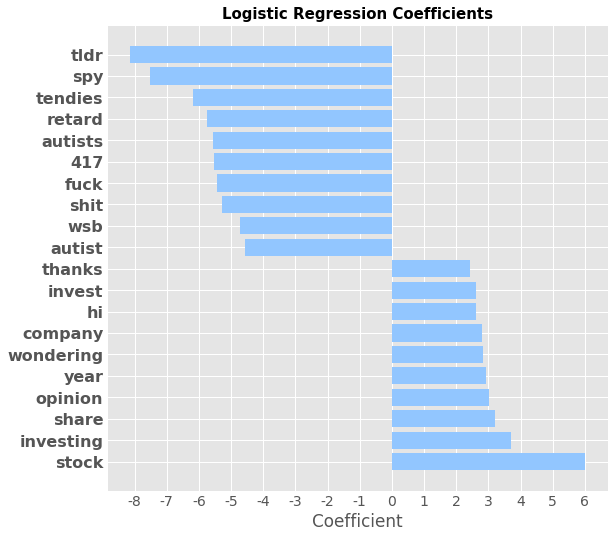

In [209]:
plt.style.use('seaborn-pastel')
plt.figure(figsize=(8, 8))
plt.barh(y=coefs_vis.index, width=coefs_vis[0])
plt.title('Logistic Regression Coefficients', fontsize=15, fontweight='bold')
plt.xlabel('Coefficient')
plt.xticks(np.arange(-8, 7,1), labels=np.arange(-8, 7, 1))
plt.yticks(fontsize=16, fontweight='bold')
plt.savefig('Coefs.jpeg', bbox_inches = "tight");

In [210]:
# Calculate ROC AUC
def roc(probas, true, step=0.01):
    probas = probas[:,1]  
    true = true.values    
    assert(len(probas) == len(true)) 
    TPRs = [] 
    FPRs = [] 
    for i in np.arange(0.0,1.0,step): 
        preds_class = probas > i 
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): 
            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
        TPR = TP/(TP + FN) 
        FPR = FP/(FP + TN)
        TPRs.append(TPR)
        FPRs.append(FPR)
    plt.figure(figsize=(8, 8))    
    plt.rcParams['font.size'] = 14
    plt.plot(FPRs, TPRs, color="orange")
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Receiver Operating Characteristic', fontsize=15, fontweight='bold')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.show()
    plt.savefig('AUC.jpeg', bbox_inches = "tight");
# Code adapted from GA-DC-DSI Lab 4.02

In [211]:
roc_tvec_lr

0.8823493174875268

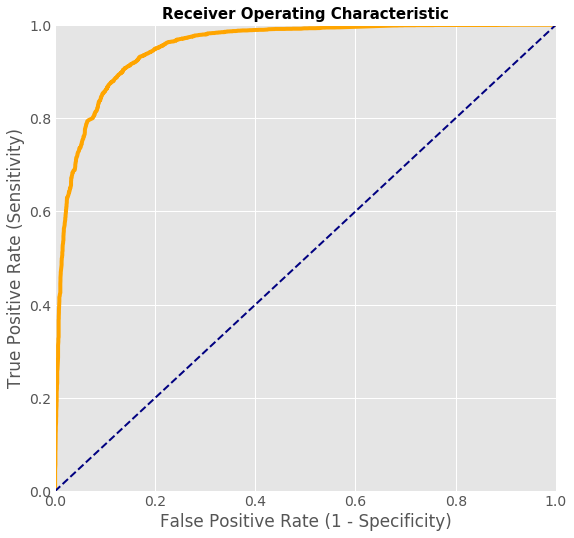

<Figure size 432x288 with 0 Axes>

In [212]:
probabilities = gs_tvec_lr.predict_proba(X_test)
roc(probas = probabilities, true = y_test, step=0.001); 